<a href="https://colab.research.google.com/github/Ashuku001/ML_NLP/blob/main/Ch8optimizing_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install datasets
!pip install accelerate==0.20.3

In [ ]:
!pip install xformers

In [ ]:
from transformers import pipeline
bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

In [17]:
# pass a query to get the predicted intent and confidence score
query = """Hi, naeza pata order ya 2inch steel nail"""
pipe(query)

[{'label': 'order', 'score': 0.3419192135334015}]

# Creating a performance benchmark

In [2]:
class PerformanceBenchMark:
  def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
    self.pipeline = pipeline
    self.dataset = dataset
    self.optim_type = optim_type

  def compute_accuracy(self):
    pass

  def compute_size(self):
    pass

  def time_pipeline(self):
    pass

  def run_benchmark(self):
    metrics = {}
    metrics[self.optim_type] = self.compute_size()
    metrics[self.optim_type].update(self.time_pipeline())
    metrics[self.optim_type].update(self.compute_accuracy())
    return metrics

In [ ]:
from datasets import load_dataset
# downloading clinc150 dataset
clinc = load_dataset("clinc_oos", "plus")

# Exploring the data

In [4]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

intent are IDs by accessing features attribute to convert to strings

In [5]:
intents = clinc["test"].features["intent"]
intents.int2str(sample['intent'])

'transfer'

In [ ]:
# Implementing compute_accuracy()
from datasets import load_metric
accuracy_score = load_metric("accuracy")

In [7]:
def compute_accuracy(self):
    """This overrides the PerformanceBenchMark.compute() method"""
    preds, labels = [], []
    for example in self.dataset:
      pred = self.pipeline(example["text"])[0]["label"]
      label = example["intent"]
      preds.append(intents.str2int(pred))
      labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchMark.compute_accuracy = compute_accuracy

In [10]:
# computing the size of our model
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.bias',
 tensor([-2.7834e-02,  4.9434e-02,  8.3551e-02,  4.1092e-02,  6.0157e-01,
          1.1774e-01, -5.2112e-02, -6.5143e-02, -2.9358e-02, -4.2250e-02,
          7.9177e-02,  8.0409e-02,  2.9921e-03,  1.7816e-01, -5.0480e-02,
         -1.5634e-01, -2.1707e-02,  1.4381e-02,  2.5132e-02, -2.4110e-02,
         -1.9183e-01, -7.8657e-02,  5.0709e-02,  3.3632e-02, -3.1946e-02,
          1.1616e-01,  9.2720e-02, -1.1787e-01,  2.3233e-01, -1.2678e-02,
         -1.3138e-01, -4.0024e-02,  7.4823e-02, -5.4148e-02, -1.5184e-01,
         -7.4407e-02,  1.1559e-01,  8.2729e-02, -1.3787e-01,  8.3528e-02,
          1.2154e-01,  1.6880e-02, -5.6629e-02, -3.9295e-02,  5.3725e-02,
          6.8602e-02, -1.1294e-01,  4.4001e-02, -2.5884e-01,  1.6767e-01,
          1.8316e-01,  5.6272e-02, -3.6874e-02, -2.7938e-02, -9.3204e-02,
         -7.5239e-03,  4.1141e-02, -1.1542e-02, -9.9749e-02, -3.0910e-02,
          4.1398e-02, -4.4389e-02, -2.6279e-02,  7.2100e-02, 

In [11]:
# saving the model
import torch
torch.save(pipe.model.state_dict(), "model.pt")

In [12]:
import torch
from pathlib import Path
def compute_size(self):
  """This overrides the PerformanceBenchMark.compute_size() method"""
  state_dict = self.pipeline.model.state_dict()
  tmp_path = Path("model.pt")
  torch.save(state_dict, tmp_path)
  # Calculate size in mb
  size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
  # Delete temporary file
  tmp_path.unlink()
  print(f"Model size (MB) - {size_mb:.2f}")
  return {"size_mb": size_mb}

PerformanceBenchMark.compute_size = compute_size

In [18]:
from time import perf_counter
for _ in range(3):
  start_time = perf_counter()
  _ = pipe(query)
  latency = perf_counter() - start_time
  print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 87.047
Latency (ms) - 83.837
Latency (ms) - 85.907


In [19]:
import numpy as np
def time_pipeline(self, query="What is the pip number for my account?"):
  """This ovverrides the PerformanceBenchmark.time_pipeline() method"""
  latencies = []
  # Warmup
  for _ in range(10):
    _ = self.pipeline(query)

  # Timed run
  for _ in range(100):
    start_time = perf_counter()
    _ = self.pipeline(query)
    latency = perf_counter() - start_time
    latencies.append(latency)

  # compute run statics
  time_avg_ms = 1000 * np.mean(latencies)
  time_std_ms = np.std(latencies)
  print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
  return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchMark.time_pipeline = time_pipeline

Now the PerformanceBenchmark is ready lets give it a spin

In [20]:
# Benchmarking our BERT baseline. we need to pass the pipeline and the dataset
# we wish to perform the benchmark on
pb = PerformanceBenchMark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.15
Average latency (ms) - 92.61 +\- 0.02
Accuracy on test set - 0.867


In [21]:
from transformers import TrainingArguments
class DistillationTrainingArguments(TrainingArguments):
  def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
    super().__init__(*args, **kwargs)
    self.alpha = alpha
    self.temperature = temperature

In [22]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
  def __init__(self, *args, teacher_model=None, **kwargs):
    super().__init__(*args, **kwargs)
    self.teacher_model = teacher_model

  def compute_loss(self, model, inputs, return_outputs=False):
    outputs_stu = model(**inputs)
    # Extract cross-entropy loss and logits from student
    loss_ce = outputs_stu.loss
    logits_stu = outputs_stu.logits
    # Extract logits from teacher
    with torch.no_grad():
      outputs_tea = self.teacher_model(**inputs)
      logits_tea = outputs_tea.logits
    # soften probabilities and compute distillation loss
    loss_fct = nn.KLDivLoss(reduction="batchmean") # average losses over the batch dimension
    loss_kd = self.args.temperature ** 2 * loss_fct(
        F.log_softmax(logits_stu / self.args.temperature, dim=-1),
        F.softmax(logits_tea / self.args.temperature, dim=-1)) # we scale the logits
    # Return weighted student loss
    loss = self.args.alpha * loss_ce + (1. -self.args.alpha) * loss_kd
    return (loss, outputs_stu) if return_outputs else loss

In [ ]:
from transformers import AutoTokenizer
student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
  return student_tokenizer(batch["text"], truncation=True)

# remove the text column
clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
# rename the intent column to labels so it is detected by trainer
clinc_enc = clinc_enc.rename_column("intent", "labels")

next define the hyperparameters and compute_metrics() function for the DistillationTrainer

In [15]:
from huggingface_hub import notebook_login
notebook_login()

In [24]:
# The metrics to track during training i.e. accuracy
def compute_metrics(pred):
  predictions, labels = pred
  # predictions are in form of logits so find most confident class prediction
  predictions = np.argmax(predictions, axis=1)
  # compare the prediction and the label
  return accuracy_score.compute(predictions=predictions, references=labels)

In [25]:
# the students training args
# set alpha=1 and see how the DistilBERT performs w/o any signal from the teacher
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy="epoch",
    num_train_epochs=5, learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01,
    push_to_hub=True
)

In [26]:
#provide the student model with the mappings between each intetn and label ID
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [27]:
# having the mappings we can create a custom model configurtin with the AutoConfig
from transformers import AutoConfig
num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels,
                                   id2label=id2label, label2id=label2id))


In [28]:
# use the configuration to AytomodelForSequenceClassification
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#  A function to initialize the student model on each new run
def student_init():
  return (AutoModelForSequenceClassification
          .from_pretrained(student_ckpt, config=student_config).to(device))

In [ ]:
# Loaiding the teacher and finetuning
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

distilbert_trainer = DistillationTrainer(model_init=student_init,
            teacher_model=teacher_model, args=student_training_args,
            train_dataset=clinc_enc["train"], eval_dataset=clinc_enc["validation"],
            compute_metrics=compute_metrics, tokenizer=student_tokenizer)

In [ ]:
distilbert_trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Cloning https://huggingface.co/Ashuku/distilbert-base-uncased-finetuned-clinc into local empty directory.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.276151,0.726129
2,3.782600,1.862473,0.838387
3,3.782600,1.151325,0.898710
4,1.686300,0.853993,0.912258
5,0.898900,0.772412,0.917097


TrainOutput(global_step=1590, training_loss=2.0456973621680303, metrics={'train_runtime': 392.194, 'train_samples_per_second': 194.419, 'train_steps_per_second': 4.054, 'total_flos': 413013830824140.0, 'train_loss': 2.0456973621680303, 'epoch': 5.0})

In [ ]:
distilbert_trainer.push_to_hub("Training completed!")

In [ ]:
# Using the stored model
finetuned_ckpt = "Ashuku/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

In [31]:
# Compute the models performance
optim_type = "DistilBERT"
pb = PerformanceBenchMark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 56.45 +\- 0.01
Accuracy on test set - 0.836


<ipython-input-32-71ac3f2b886b>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


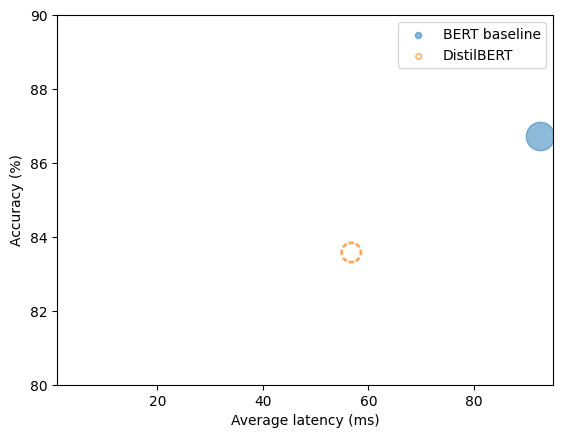

In [32]:
#To compare the results with the baseline we create a scatter plot for latency against accuracy
import pandas as pd
import matplotlib.pyplot as plt
def plot_metrics(perf_metrics, current_optim_type):
  df = pd.DataFrame.from_dict(perf_metrics, orient="index")

  for idx in df.index:
    df_opt = df.loc[idx]
    # add a dashed circle around the current optimization type
    if idx == current_optim_type:
      plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                  alpha=0.5, s=df_opt["size_mb"], label=idx,
                  marker="$\u25CC$")
    else:
      plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                  s=df_opt["size_mb"], label=idx, alpha=0.5)
  legend = plt.legend(bbox_to_anchor=(1,1))
  for handle in legend.legendHandles:
    handle.set_sizes([20])

  plt.ylim(80, 90)
  # use the slowest model to define the x-axis range
  xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
  plt.xlim(1, xlim)
  plt.ylabel("Accuracy (%)")
  plt.xlabel("Average latency (ms)")
  plt.show()

plot_metrics(perf_metrics, optim_type)

From the plot we can see that we have managed to significantly decrese the average latency at a price of 1% reduction in accuracy. Can we close the last gap by including the distilation loss of the teacher and finding good values for alpha and T

# Finding Good hyperparameters with Optuna

In [33]:
# finding the minimum of f(x,y)
def objective(trial):
  x = trial.suggest_float("x", -2, 2)
  y = trial.suggest_float("y", -2, 2)
  return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

In [ ]:
!pip install optuna

In [35]:
# optuna collects multiple trials as a study
import optuna
study = optuna.create_study()
study.optimize(objective, n_trials=2000) # creating a study

[I 2023-08-19 06:34:02,660] Trial 1998 finished with value: 105.54957370437702 and parameters: {'x': -0.019610500763352433, 'y': 1.0226857413135697}. Best is trial 843 with value: 0.0009358315941215904.
[I 2023-08-19 06:34:02,728] Trial 1999 finished with value: 181.73940352955736 and parameters: {'x': -0.4941147645086049, 'y': 1.583951716520838}. Best is trial 843 with value: 0.0009358315941215904.


In [36]:
# from the study the best parameters
study.best_params # it is close the global minimum of (1, 1)

{'x': 1.0090387278155082, 'y': 1.015236598853794}

Optuna in transformers: first define the hyperparameter space that we wish to optimize in addition to alpha and T we include the number of training epochs

In [37]:
# Using optuna in transformers
def hp_space(trial):
  return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
          "alpha": trial.suggest_float("alpha", 0, 1),
          "temperature": trial.suggest_int("temperature", 2, 20)}

Running hyperparameter seach with the Trainer we need to specify the number of trials to run and a direction to optimize for. For best accuracy we specify direction="maximize" and pass the hp_search space in hyperparameter_search

In [38]:
best_run = distilbert_trainer.hyperparameter_search(n_trials=20,
                                                    direction="maximize",
                                                    hp_space=hp_space)

[I 2023-08-19 06:34:02,764] A new study created in memory with name: no-name-e338f2f0-ff1a-4adc-a8c5-af8e05944c6b
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded en

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.252988,0.641935
2,0.400600,0.109922,0.844839
3,0.400600,0.066812,0.899677
4,0.127500,0.047982,0.909677
5,0.074200,0.038895,0.919677
6,0.074200,0.033670,0.921613
7,0.056500,0.030588,0.923548
8,0.048400,0.028944,0.925806
9,0.048400,0.027733,0.925484
10,0.044600,0.027324,0.925484


[I 2023-08-19 06:48:11,123] Trial 0 finished with value: 0.925483870967742 and parameters: {'num_train_epochs': 10, 'alpha': 0.22341091320885376, 'temperature': 4}. Best is trial 0 with value: 0.925483870967742.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilB

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.229730,0.608710
2,0.359700,0.112256,0.830645
3,0.359700,0.075239,0.883871
4,0.129200,0.059121,0.896129
5,0.085400,0.051883,0.908710
6,0.085400,0.049453,0.908387


[I 2023-08-19 06:55:41,808] Trial 1 finished with value: 0.9083870967741936 and parameters: {'num_train_epochs': 6, 'alpha': 0.38266376681711056, 'temperature': 6}. Best is trial 0 with value: 0.925483870967742.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilB

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.296655,0.657097
2,0.464300,0.123092,0.841935
3,0.464300,0.071972,0.892581
4,0.142800,0.051940,0.908065
5,0.081100,0.042777,0.916129
6,0.081100,0.038059,0.919677
7,0.062800,0.035457,0.921290
8,0.055900,0.034624,0.922903


[I 2023-08-19 07:05:53,430] Trial 2 finished with value: 0.9229032258064516 and parameters: {'num_train_epochs': 8, 'alpha': 0.5310050590492785, 'temperature': 3}. Best is trial 0 with value: 0.925483870967742.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBe

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.194228,0.586129
2,0.311100,0.094057,0.838387
3,0.311100,0.062762,0.892258
4,0.108200,0.047331,0.903871
5,0.068500,0.039233,0.914194
6,0.068500,0.034225,0.917419
7,0.053700,0.031027,0.918710
8,0.046400,0.029253,0.921935
9,0.046400,0.028027,0.922258
10,0.042800,0.027624,0.922581


[I 2023-08-19 07:18:36,382] Trial 3 finished with value: 0.9225806451612903 and parameters: {'num_train_epochs': 10, 'alpha': 0.8870776807765013, 'temperature': 17}. Best is trial 0 with value: 0.925483870967742.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Distil

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.222447,0.622903
2,0.354300,0.102439,0.842903
3,0.354300,0.065350,0.897419
4,0.118500,0.047988,0.906774
5,0.072000,0.039157,0.917742
6,0.072000,0.033919,0.919355
7,0.055500,0.030697,0.922258
8,0.047700,0.028957,0.925806
9,0.047700,0.027710,0.923548
10,0.043900,0.027303,0.923226


[I 2023-08-19 07:32:23,561] Trial 4 finished with value: 0.9232258064516129 and parameters: {'num_train_epochs': 10, 'alpha': 0.8504064340679055, 'temperature': 6}. Best is trial 0 with value: 0.925483870967742.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilB

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.213482,0.589677


[I 2023-08-19 07:33:20,509] Trial 5 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.308553,0.641935
2,0.473200,0.141009,0.818387


[I 2023-08-19 07:35:48,335] Trial 6 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.204093,0.591613


[I 2023-08-19 07:36:45,716] Trial 7 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.196426,0.582258


[I 2023-08-19 07:37:42,936] Trial 8 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.202425,0.583226


[I 2023-08-19 07:38:39,861] Trial 9 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.216606,0.613226


[I 2023-08-19 07:39:36,859] Trial 10 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifie

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.233621,0.631290
2,0.371300,0.105294,0.843548
3,0.371300,0.065990,0.898710
4,0.122000,0.047988,0.907419
5,0.073000,0.039042,0.919032
6,0.073000,0.033762,0.920000
7,0.055900,0.030573,0.923548
8,0.048000,0.028876,0.925484
9,0.048000,0.027640,0.924516
10,0.044200,0.027229,0.925161


[I 2023-08-19 07:52:29,109] Trial 11 finished with value: 0.9251612903225807 and parameters: {'num_train_epochs': 10, 'alpha': 0.982841059612335, 'temperature': 5}. Best is trial 0 with value: 0.925483870967742.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilB

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.292811,0.660323
2,0.461400,0.117913,0.844839
3,0.461400,0.067815,0.896452
4,0.137300,0.048177,0.910645
5,0.075900,0.039082,0.919355
6,0.075900,0.034069,0.924516
7,0.057300,0.031152,0.926774
8,0.049200,0.029641,0.927419
9,0.049200,0.028444,0.926774
10,0.045400,0.028043,0.927742


[I 2023-08-19 08:05:57,931] Trial 12 finished with value: 0.927741935483871 and parameters: {'num_train_epochs': 10, 'alpha': 0.9657653865017712, 'temperature': 3}. Best is trial 12 with value: 0.927741935483871.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Distil

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.410991,0.674839
2,0.642300,0.143960,0.834839


[I 2023-08-19 08:08:44,882] Trial 13 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifie

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.199284,0.589677


[I 2023-08-19 08:09:48,725] Trial 14 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifie

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.206729,0.603871


[I 2023-08-19 08:10:57,017] Trial 15 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifie

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.193204,0.578387


[I 2023-08-19 08:12:00,899] Trial 16 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifie

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.258321,0.635484
2,0.404600,0.117187,0.837419


[I 2023-08-19 08:14:52,278] Trial 17 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifie

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.210579,0.610968


[I 2023-08-19 08:15:55,643] Trial 18 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifie

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.410991,0.674839
2,0.642300,0.143960,0.834839


[I 2023-08-19 08:18:43,344] Trial 19 pruned. 


In [39]:
print(best_run)

BestRun(run_id='12', objective=0.927741935483871, hyperparameters={'num_train_epochs': 10, 'alpha': 0.9657653865017712, 'temperature': 3}, run_summary=None)


the value of alpha show most of the training signal is coming from the knowledge distillation term. Updating the training args with these values and run the training run

In [40]:
for k,v in best_run.hyperparameters.items():
  setattr(student_training_args, k, v)

# Define a new repository to store distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# Create a new Trainer with optimal parameters we got from above in the best_run
distil_trainer = DistillationTrainer(model_init=student_init,
        teacher_model=teacher_model, args=student_training_args,
        train_dataset=clinc_enc["train"], eval_dataset=clinc_enc["validation"],
        compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.we

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.078282,0.733226
2,3.596200,1.519259,0.861613
3,3.596200,0.767363,0.914194
4,1.304400,0.468059,0.935484
5,0.440500,0.349191,0.941290
6,0.440500,0.304014,0.945484
7,0.199000,0.286295,0.947419
8,0.122400,0.273582,0.948065
9,0.122400,0.274008,0.948387
10,0.095300,0.272143,0.950000


TrainOutput(global_step=3180, training_loss=0.9105670952946885, metrics={'train_runtime': 814.6189, 'train_samples_per_second': 187.204, 'train_steps_per_second': 3.904, 'total_flos': 826338438271332.0, 'train_loss': 0.9105670952946885, 'epoch': 10.0})

We have been able to train the student to match the accuracy of the teacher despite having almost half the number of parameters. Achived 95% accuracy

In [ ]:
# save the optimized student
distil_trainer.push_to_hub("Training complete")

In [42]:
# Benchmarking the distilled model
distilled_ckpt = "Ashuku/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchMark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 48.44 +\- 0.01
Accuracy on test set - 0.886


<ipython-input-32-71ac3f2b886b>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


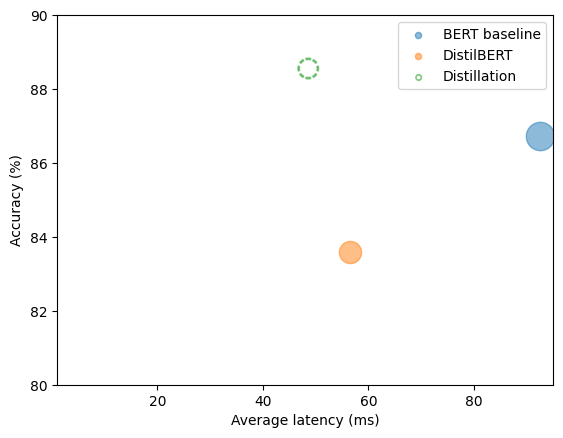

In [43]:
# Visualizing this performance
plot_metrics(perf_metrics, optim_type)

The model size and latency remain unchanged to DistilBERT benchmark but accuracy has improved and even surpass the teacher. The teacher was not fine-tuned as systematically as the student.


# Making models faster with Quantization

Why transformers are prime candidates for quantization is that the weights and activations tend to take values in relatively small ranges.

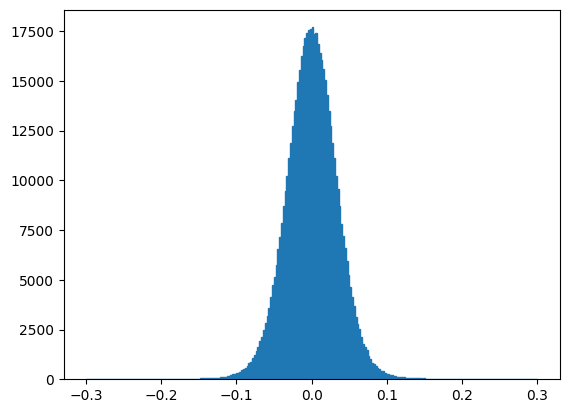

In [45]:
# One attention weight matrices from our distilled model and plot the frequency distribution values
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3, 0.3), edgecolor="C0")
plt.show()

We see the value of weights are distributed in the small range of [-0.1,0.1] around zero. suppose we quantize this tensor as a signed 8-bit integer. therefore the range of possible values for our integers is [qmax, qmin] = [-128, 127] with zero point coinciding with the zero of FP32 and the scale factor is calculated according to previous equation

In [46]:
zero_point=0
scale = (weights.max() - weights.min()) / (127 -(-128))

In [47]:
#To obtain the quantized tensor we invert the mapping q=f/s + z clamp the values
# round them to nearest int and represent the result in torch.int8 data using Tensor.char() function
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -5,   5,  ...,   0,   5,  -4],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  11,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -1]], dtype=torch.int8)

To simplify the above operation using quantize_per_tensor() with quantized data type torch.qint that is optimized for integer arithmentic operation

In [48]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -5,   5,  ...,   0,   5,  -4],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  11,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -1]], dtype=torch.int8)

In [49]:
# compare how long it takes to compute the multiplication of tow weights tensors
#  with FP32 and INT8 values
%%timeit
# for FP32
weights @ weights

14.1 ms ± 3.48 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [50]:
# For quantized tensors we need QFunctional class
from torch.nn.quantized import QFunctional
q_fn = QFunctional

In [51]:
#comparing storage size of weight tensor and its quantized cousing
# using Tensor.storage()
import sys
sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

<ipython-input-51-a64cf3d2fb58>:4: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())


3.999755879241598

In [52]:
# Implementing dynamic quantization
from torch.quantization import quantize_dynamic
model_ckpt = "Ashuku/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))
# pass the full-precision model specify the set of PyTorch layer classes in
# that model that we want to quantize. dtype specify the target precission
model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)


In [54]:
# Benchmarking our quantized model
pipe = pipeline("text-classification", model=model_quantized,
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchMark(pipe, clinc['test'], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 132.39
Average latency (ms) - 24.16 +\- 0.00
Accuracy on test set - 0.891


<ipython-input-32-71ac3f2b886b>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


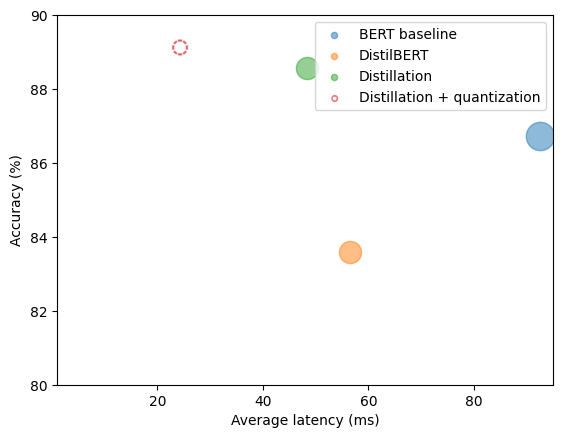

In [55]:
plot_metrics(perf_metrics, optim_type)

The quantized model is almost half the size of our distilled one and has eve gained a slight accuracy boost

# Optimizing Inference with ONNX and the ONNX Runtime

To convert our model into ONNX format using convert_graph_to_onnx.convert()

In [1]:
# first set some OpenMP environment variables for ONNX
import os
from psutil import cpu_count
 # set the number of threada to use for parallel computation n the ORT
os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
# specify that waiting threads should be active(i.e. using CPU cycles)
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [ ]:
# convert the model to ONNX format
from transformers.convert_graph_to_onnx import convert
model_ckpt = "Ashuku/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework='pt', model=model_ckpt, tokenizer=tokenizer,
        output=onnx_model_path, opset=12, pipeline_name="text-classification")
# ONNX uses operator sets to group together immutable operator specs so opset=12 corresponds to a specific version of the ONNX library

In [ ]:
!pip install onnxruntime

In [ ]:
# Now that our model is saved
# Create an InferenceSession instance to feed inputs to the model:
from onnxruntime import (GraphOptimizationLevel, InferenceSession, SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
  options = SessionOptions()
  options.intra_op_num_threads = 1
  options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
  session = InferenceSession(str(model_path), options, providers=[provider])
  session.disable_fallback()
  return session

onnx_model = create_model_for_provider(onnx_model_path)

Now when we run onnx_model.run() we can get class logits from teh ONNX model. Testing it with the test set

In [ ]:
# The output from convert shows that ONNX expects just the input_ids and attention_mask as inputs
# we drop the label column
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

In [ ]:
# With the logits we can get predicted label by taking the argmax
np.argmax(logits_onnx)

ONNX model is not compatible with the text-classification pipeline so we create our own class that mimics the core behavior

In [ ]:
from scipy.special import softmax

class OnnxPipeline:
  def __init__(self, model, tokenizer):
    self.model = model
    self.tokenizer = tokenizer

  def __call__(self, query):
    model_inputs = self.tokenizer(query, return_tensors="pt")
    inputs_onnx = {k: v.cpu().detach().numpy()
                  for k, v in model_inputs.items()}
    logits = self.model.run(None, inputs_onnx)[0][0, :]
    probs = softmax(logits)
    pred_idx = np.argmax(probs).item()
    return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [ ]:
# testing on our simpe query see it we get the same intent
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

Great the pipeline works. Next is create a performance benchmark for ONNX models. We only override the compute_size() method of PerformacneBenchMark class since we cannot rely on state_dict and torch.save() to measure a model's size since onnx_model is an ONNX InferenceSession object that doesnt have access to the attributes of PyTorch's nn.module

In [ ]:
# performance benchmark for ONNX models
class OnnxPerformanceBenchmark(PerformanceBenchMark):
  def __init__(self, *args, model_path, **kwargs):
    super().__init__(*args, **kwargs)
    self.model_path = model_path

  def compute_size(self):
    size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

In [ ]:
# Checking how distilled model performs when conveted to ONNX format
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

In [ ]:
plot_metrics(perf_metrics, optim_type)